In [1]:
from typing import Annotated
from typing_extensions import TypedDict
import os
## Working With Tools

from dotenv import load_dotenv
load_dotenv()
from langchain_community.utilities import WikipediaAPIWrapper , DuckDuckGoSearchAPIWrapper, GoogleSearchAPIWrapper
from langchain_community.tools import WikipediaQueryRun , DuckDuckGoSearchResults
from tools import CurrentDateTimeTool, ShippingTimeEstimator, PromoCodeScraper , calculator , get_current_location , scrape_and_crawl
from langchain_core.tools import Tool

In [2]:


search = GoogleSearchAPIWrapper()



Google_search = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search.run,
)


api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

api_wrapper = DuckDuckGoSearchAPIWrapper(region="de-de", time="d", max_results=2)
DuckDuckGo = DuckDuckGoSearchResults(api_wrapper=api_wrapper, source="news")


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1303/1333598552.py:1: LangChainDeprecationWarning: The class `GoogleSearchAPIWrapper` was deprecated in LangChain 0.0.33 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-google-community package and should be used instead. To use it run `pip install -U :class:`~langchain-google-community` and import as `from :class:`~langchain_google_community import GoogleSearchAPIWrapper``.
  search = GoogleSearchAPIWrapper()


In [3]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [4]:
CurrentDateTimeTool.invoke(input="")

'Today is Tuesday, March 04, 2025 15:34:44.'

In [5]:
tools=[wiki_tool,CurrentDateTimeTool,ShippingTimeEstimator,PromoCodeScraper,DuckDuckGo,Google_search,calculator,get_current_location,scrape_and_crawl]

In [6]:
len(tools)

9

In [7]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [8]:
from langgraph.graph import StateGraph,START,END

In [9]:
graph_builder= StateGraph(State)

In [10]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

True

In [11]:

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

In [12]:
llm= ChatOpenAI(model_name="gpt-3.5-turbo")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x12546aa50>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x12547a660>, root_client=<openai.OpenAI object at 0x123f452b0>, root_async_client=<openai.AsyncOpenAI object at 0x12546aba0>, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [13]:
llm_with_tools=llm.bind_tools(tools=tools)

In [14]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [15]:
from langgraph.prebuilt import ToolNode,tools_condition

In [16]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [17]:
graph=graph_builder.compile()

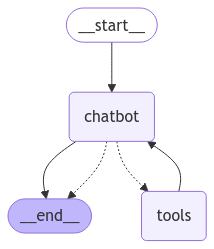

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print("Error: ",e)

In [19]:
user_input="Find a floral skirt under $40 in size S. Is it in stock, and can I apply a discount code ‘SAVE10’?"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Find a floral skirt under $40 in size S. Is it in stock, and can I apply a discount code ‘SAVE10’?
================================== Ai Message ==================================
Tool Calls:
  scrape_and_crawl (call_NMfUGKoQmAZ1rUw4V2X3gsPj)
 Call ID: call_NMfUGKoQmAZ1rUw4V2X3gsPj
  Args:
    url: https://www.example.com/floral-skirts-size-s-under-40
  promo_code_scraper (call_xqsWLFPsssnbZSKUga9q8z33)
 Call ID: call_xqsWLFPsssnbZSKUga9q8z33
  Args:
    store: example
    source: retailmenot
================================= Tool Message =================================
Name: promo_code_scraper

[{"error": "Failed to fetch data: 403 Client Error: Forbidden for url: https://www.retailmenot.com/view/example"}]
================================== Ai Message ==================================

I encountered an issue while trying to fetch the information for you. It seems there was a problem accessing the nec

## Procedural memory

In [20]:
%%capture cap --no-stderr
%pip install -U langmem langgraph

In [20]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()
store.put(("instructions",), key="agent_instructions", value={"prompt": "Help customer to find it's product and solve it's problem"})

In [21]:
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store


def prompt(state):
    item = store.get(("instructions",), key="agent_instructions")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

agent = create_react_agent("gpt-3.5-turbo", prompt=prompt, tools=tools, store=store)

In [22]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Find a floral skirt under $40 in size S. Is it in stock, and can I apply a discount code ‘SAVE10’?"}]}
)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

I couldn't find the information about a floral skirt under $40 in size S and its availability in stock. Additionally, I encountered an error while trying to fetch data for the discount code 'SAVE10'. 

You may want to try searching for the floral skirt on specific clothing websites or contact the stores directly to inquire about the product and its availability. Additionally, you can check the SAVE10 discount code on the retailer's website directly or contact their customer service for more information.


In [23]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer("gpt-3.5-turbo")

In [24]:
current_prompt = store.get(("instructions",), key="agent_instructions").value["prompt"]
feedback = {"request": "Always sign off from Shoppin Fashon AI; Enjoy Shopping see you soon!!"}

optimizer_result = optimizer.invoke({"prompt": current_prompt, "trajectories": [(result["messages"], feedback)]})
 

In [25]:
print(optimizer_result)

Provide precise instructions to the customer on searching multiple clothing websites for a floral skirt under $40 in size S. Additionally, advise them to contact stores directly for stock availability inquiries. For troubleshooting discount codes, recommend verifying them on retailer websites.


In [26]:
store.put(("instructions",), key="agent_instructions", value={"prompt": optimizer_result})

In [27]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Find a floral skirt under $40 in size S. Is it in stock, and can I apply a discount code ‘SAVE10’?"}]}
)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

I have searched multiple websites for a floral skirt under $40 in size S. Here are the findings:

1. ASOS: I found a vintage floral awkward length slip dress for $28. Unfortunately, it seems to be out of stock.
2. Zara: I didn't find any specific floral skirt under $40 in size S on Zara's website.
3. Forever 21: They have a floral print maxi skirt priced at $26.06. You can check for its availability on their website.
4. H&M: I didn't find any relevant floral skirts under $40 in size S on the H&M website.

For stock availability, I recommend visiting the respective websites directly and checking the product pages. As for the discount code 'SAVE10', I couldn't find any information on its applicability on the searched items. If you have a specific store in mind where you would like to apply the discount code, let me know, and I can help you verify its validity on their website.


In [28]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" : "I need white sneakers (size 8) for under $70 that can arrive by Friday."}]}
)
result['messages'][-1].pretty_print()


================================== Ai Message ==================================

I found some options for white sneakers in size 8 under $70 that can arrive by Friday:

1. Men's White Tennis Shoes Low Top Fashion Sneakers for $59.95 with FREE delivery by Saturday, March 8 on $35 of items shipped by Amazon.
2. Sam Edelman Women's Ethyl Lace Up Sneaker for $71.90, available in size 8 with shipping options.
3. HWJHMX Girls Cheer Shoes White Youth Cheerleading.

You can explore these options further and check the specific delivery details on the respective websites.


In [29]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" : "I need white sneakers (size 8) for under $70 that can arrive by Friday, and give the list with link too"}]}
)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

I found some options for white sneakers in size 8 under $70 that can possibly arrive by Friday:

1. **Low Top Fashion Sneakers for Men - $59.95**
   - Available on Amazon with free delivery on orders over $35.
   - [More details and purchase here](https://www.amazon.com/)
   
2. **Nike Boy's Sneakers - Price not specified**
   - Available, but price information is missing.
   - [More details and purchase here](https://www.amazon.com/)

3. **Sam Edelman Women's Ethyl Lace Up Sneaker - $71.90 (slightly above budget)**
   - Available for purchase.
   - [More details and purchase here](https://www.amazon.com/)

Unfortunately, the third option is slightly above your budget. You can explore more details and make a purchase on Amazon through the provided links.


## Multi-agent

In [32]:
%%capture cap --no-stderr
%pip install -U langgraph-supervisor

In [31]:
from langgraph.store.memory import InMemoryStore
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import Tool
from langchain_community.utilities import WikipediaAPIWrapper, DuckDuckGoSearchAPIWrapper, GoogleSearchAPIWrapper
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchResults
import datetime
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from typing import List, Dict, Optional
import logging
import geocoder

logger = logging.getLogger(__name__)

store = InMemoryStore()

tools=[wiki_tool,CurrentDateTimeTool,ShippingTimeEstimator,PromoCodeScraper,DuckDuckGo,Google_search,calculator,get_current_location,scrape_and_crawl]



print("All tools initialized successfully!")


All tools initialized successfully!


In [32]:
from langgraph.store.memory import InMemoryStore
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store

store = InMemoryStore()

# Define tool instructions
store.put(("instructions",), key="search_agent", value={"prompt": "Search the web for relevant information."})
store.put(("instructions",), key="wiki_agent", value={"prompt": "Retrieve concise Wikipedia summaries."})
store.put(("instructions",), key="promo_code_agent", value={"prompt": "Find active promo codes for online stores."})
store.put(("instructions",), key="shipping_agent", value={"prompt": "Estimate shipping costs and delivery times."})
store.put(("instructions",), key="calculator_agent", value={"prompt": "Perform mathematical calculations."})
store.put(("instructions",), key="location_agent", value={"prompt": "Retrieve the user's current location."})
store.put(("instructions",), key="scraper_agent", value={"prompt": "Scrape and crawl web pages for data."})
store.put(("instructions",), key="datetime_agent", value={"prompt": "Retrieve the current date and time."})


In [64]:
def prompt_search(state):
    item = store.get(("instructions",), key="search_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_wiki(state):
    item = store.get(("instructions",), key="wiki_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_promo_code(state):
    item = store.get(("instructions",), key="promo_code_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_shipping(state):
    item = store.get(("instructions",), key="shipping_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_calculator(state):
    item = store.get(("instructions",), key="calculator_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_location(state):
    item = store.get(("instructions",), key="location_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_scraper(state):
    item = store.get(("instructions",), key="scraper_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

def prompt_datetime(state):
    item = store.get(("instructions",), key="datetime_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

In [65]:
# Initialize agents
search_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_search, tools=[GoogleSearchAPIWrapper,DuckDuckGo], store=store, name="search_agent")
wiki_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_wiki, tools=[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300))], store=store, name="wiki_agent")
promo_code_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_promo_code, tools=[PromoCodeScraper], store=store, name="promo_code_agent")
shipping_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_shipping, tools=[ShippingTimeEstimator], store=store, name="shipping_agent")
calculator_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_calculator, tools=[calculator], store=store, name="calculator_agent")
location_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_location, tools=[get_current_location], store=store, name="location_agent")
scraper_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_scraper, tools=[scrape_and_crawl], store=store, name="scraper_agent")
datetime_agent = create_react_agent("gpt-3.5-turbo", prompt=prompt_datetime, tools=[CurrentDateTimeTool], store=store, name="datetime_agent")

In [66]:
from langgraph_supervisor import create_supervisor

# Create supervisor workflow
workflow = create_supervisor(
    [search_agent, wiki_agent,promo_code_agent,shipping_agent,calculator_agent,location_agent,scraper_agent,datetime_agent],
    model="gpt-3.5-turbo",
    prompt=(
        "You are a team supervisor managing multiple AI agents to assist with various tasks and a virtual shopping assistant that helps online shoppers navigate multiple fashion e-commerce platforms. You interpret user requests, decide which external tools to use, and integrate the obtained information to provide clear and helpful responses."
    )
)

# Compile and run
app = workflow.compile(store=store)



In [67]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content": "Find a floral skirt under $40 in size S. Is it in stock, and can I apply a discount code ‘SAVE10’?"}
    ]}
)

print(result)  # Check intermediate steps for missing tool responses


ValueError: Found AIMessages with tool_calls that do not have a corresponding ToolMessage. Here are the first few of those tool calls: [{'name': 'transfer_to_promo_code_agent', 'args': {'code': 'SAVE10'}, 'id': 'call_TkTJel4nTlnucqBesGsGLY3o', 'type': 'tool_call'}].

Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage (result of a tool invocation to return to the LLM) - this is required by most LLM providers.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CHAT_HISTORY

In [68]:
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

I found some options for white sneakers in size 8 under $70 that can possibly arrive by Friday:

1. **Low Top Fashion Sneakers for Men - $59.95**
   - Available on Amazon with free delivery on orders over $35.
   - [More details and purchase here](https://www.amazon.com/)
   
2. **Nike Boy's Sneakers - Price not specified**
   - Available, but price information is missing.
   - [More details and purchase here](https://www.amazon.com/)

3. **Sam Edelman Women's Ethyl Lace Up Sneaker - $71.90 (slightly above budget)**
   - Available for purchase.
   - [More details and purchase here](https://www.amazon.com/)

Unfortunately, the third option is slightly above your budget. You can explore more details and make a purchase on Amazon through the provided links.


In [69]:
from langmem import create_multi_prompt_optimizer

feedback = {"request": "Always sign off from Shoppin Fashon AI; Enjoy Shopping see you soon!!"}

optimizer = create_multi_prompt_optimizer("anthropic:claude-3-5-sonnet-latest")

In [70]:
from langmem import Prompt
?Prompt

Init signature: Prompt(self, /, *args, **kwargs)
Docstring:     
TypedDict for structured prompt management and optimization.

Example:
    ```python
    from langmem import Prompt

    prompt = Prompt(
        name="extract_entities",
        prompt="Extract key entities from the text:",
        update_instructions="Make minimal changes, only address where"
        " errors have occurred after reasoning over why they occur.",
        when_to_update="If there seem to be errors in recall of named entities.",
    )
    ```

The name and prompt fields are required. Optional fields control optimization:
- update_instructions: Guidelines for modifying the prompt
- when_to_update: Dependencies between prompts during optimization

Use in the prompt optimizers.
File:           /opt/anaconda3/envs/llm_agent/lib/python3.13/site-packages/langmem/prompts/types.py
Type:           _TypedDictMeta
Subclasses:     

In [71]:
# wiki_prompt = store.get(("instructions",), key="wiki_agent").value['prompt']
# datetime_prompt = store.get(("instructions",), key="datetime_agent").value['prompt']
# shipping_prompt = store.get(("instructions",), key="shipping_agent").value['prompt']
# promo_prompt = store.get(("instructions",), key="promo_agent").value['prompt']
# duckduckgo_prompt = store.get(("instructions",), key="duckduckgo_agent").value['prompt']
# google_prompt = store.get(("instructions",), key="google_agent").value['prompt']
# calculator_prompt = store.get(("instructions",), key="calculator_agent").value['prompt']
# location_prompt = store.get(("instructions",), key="location_agent").value['prompt']
# scrape_crawl_prompt = store.get(("instructions",), key="scrape_crawl_agent").value['prompt']
def safe_get_prompt(agent_key):
    item = store.get(("instructions",), key=agent_key)
    return item.value['prompt'] if item else print("Default prompt or error handling message",agent_key)

datetime_prompt = safe_get_prompt("datetime_agent")
shipping_prompt = safe_get_prompt("shipping_agent")
promo_prompt = safe_get_prompt("promo_agent")
duckduckgo_prompt = safe_get_prompt("duckduckgo_agent")
google_prompt = safe_get_prompt("google_agent")
calculator_prompt = safe_get_prompt("calculator_agent")
location_prompt = safe_get_prompt("location_agent")
scrape_crawl_prompt = safe_get_prompt("scrape_crawl_agent")
wiki_prompt = safe_get_prompt("wiki_agent")

wiki_prompt = {
    "name": "wiki_prompt",
    "prompt": wiki_prompt,
    "when_to_update": "Update if Wikipedia search results are inaccurate, outdated, or lack sufficient detail for user queries."
}

datetime_prompt = {
    "name": "datetime_prompt",
    "prompt": datetime_prompt,
    "when_to_update": "Update if the date/time format needs localization, time zones are incorrect, or response speed is slow."
}

shipping_prompt = {
    "name": "shipping_prompt",
    "prompt": shipping_prompt,
    "when_to_update": "Update if shipping cost or delivery time estimates are inaccurate, missing key carrier options, or not reflecting real-time data."
}

promo_prompt = {
    "name": "promo_prompt",
    "prompt": promo_prompt,
    "when_to_update": "Update if promo codes are expired, missing from key sources, or fail to provide valid discounts on supported platforms."
}

duckduckgo_prompt = {
    "name": "duckduckgo_prompt",
    "prompt": duckduckgo_prompt,
    "when_to_update": "Update if search results lack relevance, miss recent updates, or return incomplete or unverified information."
}

google_prompt = {
    "name": "google_prompt",
    "prompt": google_prompt,
    "when_to_update": "Update if search results are outdated, irrelevant, or fail to retrieve comprehensive information from authoritative sources."
}

calculator_prompt = {
    "name": "calculator_prompt",
    "prompt": calculator_prompt,
    "when_to_update": "Update if calculations are inaccurate, fail to support additional operations (e.g., percentages, advanced math), or execution speed is slow."
}

location_prompt = {
    "name": "location_prompt",
    "prompt": location_prompt,
    "when_to_update": "Update if location data is incorrect, fails to detect user’s region, or lacks sufficient details like city, state, or country."
}

scrape_crawl_prompt = {
    "name": "scrape_crawl_prompt",
    "prompt": scrape_crawl_prompt,
    "when_to_update": "Update if web scraping retrieves outdated, incomplete, or irrelevant data, or if crawling speed needs optimization for large-scale websites."
}


Default prompt or error handling message promo_agent
Default prompt or error handling message duckduckgo_agent
Default prompt or error handling message google_agent
Default prompt or error handling message scrape_crawl_agent


In [72]:
store.get(("instructions",), key="wiki_agent").value['prompt']

'Retrieve concise Wikipedia summaries.'

In [73]:
promo_prompt = store.get(("instructions",), key="promo_agent").value['prompt']


AttributeError: 'NoneType' object has no attribute 'value'

In [74]:
optimizer_result = optimizer.invoke({
    "prompts": [
        datetime_prompt, 
        shipping_prompt, 
        promo_prompt, 
        duckduckgo_prompt, 
        google_prompt, 
        calculator_prompt, 
        location_prompt, 
        scrape_crawl_prompt
    ],
    "trajectories": [(result["messages"], feedback)]
})


TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

In [75]:
optimizer_result

'Provide precise instructions to the customer on searching multiple clothing websites for a floral skirt under $40 in size S. Additionally, advise them to contact stores directly for stock availability inquiries. For troubleshooting discount codes, recommend verifying them on retailer websites.'

In [76]:
store.put(("instructions",), key="email_agent", value={"prompt": optimizer_result[1]['prompt']})

TypeError: string indices must be integers, not 'str'

In [77]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :""}]},
)